In [1]:
import requests
import os
import pandas as pd
import matplotlib.pyplot as plt
import json
import tensorflow as tf
import numpy as np

In [2]:
# def list_dataset_codes():
api_endpoint = "https://api.ons.gov.uk/"
api_params = 'code-lists'
url = (api_endpoint
                    + api_params)
                        
#     return requests.get(url).json()
    

In [3]:
requests.get(url).json()

'No API is defined for GET /code-lists'

In [5]:
def grab_ONS_time_series_data(dataset_id,timeseries_id):
    """ This function grabs specified time series from the ONS API. """
    api_endpoint = "https://api.ons.gov.uk/"
    api_params = {
    'dataset':dataset_id,
    'timeseries':timeseries_id}
    url = (api_endpoint
                        +'/'.join([x+'/'+y for x,y in zip(api_params.keys(),api_params.values())][::-1])
                        +'/data')
    print(url)
    return requests.get(url).json()

https://api.ons.gov.uk/timeseries/D7BU/dataset/MM23/data
Code output:

CPI INDEX 01 : FOOD AND NON-ALCOHOLIC BEVERAGES 2015=100
               label     month quarter sourceDataset  \
date                                                   
1988-01-01  1988 JAN   January                  MM23   
1988-02-01  1988 FEB  February                  MM23   
1988-03-01  1988 MAR     March                  MM23   
1988-04-01  1988 APR     April                  MM23   
1988-05-01  1988 MAY       May                  MM23   

                          updateDate  value  year  
date                                               
1988-01-01  2016-01-19T09:30:00.000Z   48.0  1988  
1988-02-01  2016-01-19T09:30:00.000Z   48.3  1988  
1988-03-01  2016-01-19T09:30:00.000Z   48.4  1988  
1988-04-01  2016-01-19T09:30:00.000Z   48.7  1988  
1988-05-01  2016-01-19T09:30:00.000Z   48.8  1988  


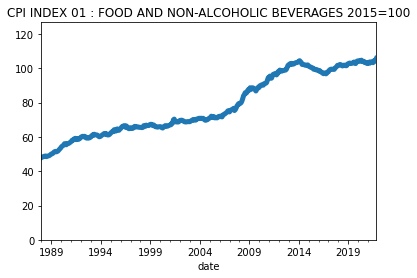

In [6]:
# Grab the data (put your time series codes here) 

data = grab_ONS_time_series_data('MM23','D7BU')

# Check we have the right time series 
title_text = data['description']['title']
print("Code output:\n")
print(title_text)
# Put the data into a dataframe and convert types # Note that you'll need to change months if you're 
# using data at a different frequency 
df = pd.DataFrame(pd.json_normalize(data['months']))
# Put the data in a standard datetime format
df['date'] = pd.to_datetime(df['date'])
df['value'] = df['value'].astype(float)
df = df.set_index('date')
# Check the data look sensible 
print(df.head())
# Plot the data 
df['value'].plot(title=title_text,ylim=(0,df['value'].max()*1.2),lw=5.)
plt.show()

In [7]:
#--- convert to a Tensorflow timeseries dataset

df.head()

,label,month,quarter,sourceDataset,updateDate,value,year
date,,,,,,,
1988-01-01,1988 JAN,January,,MM23,2016-01-19T09:30:00.000Z,48.0,1988
1988-02-01,1988 FEB,February,,MM23,2016-01-19T09:30:00.000Z,48.3,1988
1988-03-01,1988 MAR,March,,MM23,2016-01-19T09:30:00.000Z,48.4,1988
1988-04-01,1988 APR,April,,MM23,2016-01-19T09:30:00.000Z,48.7,1988
1988-05-01,1988 MAY,May,,MM23,2016-01-19T09:30:00.000Z,48.8,1988


In [8]:
 x1 = tf.cast(df['value'],tf.float32)

In [9]:
#--- split into train and test
df = df.reset_index(drop = True)

column_indices = {name: i for i, name in enumerate(df.columns)}
n = len(df)

train_df = df[0:int(n*0.7)][['value']]
val_df = df[int(n*0.7):int(n*0.9)][['value']]
test_df = df[int(n*0.9):]

num_features = df.shape[1]
num_features

7

In [10]:
df

,label,month,quarter,sourceDataset,updateDate,value,year
0,1988 JAN,January,,MM23,2016-01-19T09:30:00.000Z,48.0,1988
1,1988 FEB,February,,MM23,2016-01-19T09:30:00.000Z,48.3,1988
2,1988 MAR,March,,MM23,2016-01-19T09:30:00.000Z,48.4,1988
3,1988 APR,April,,MM23,2016-01-19T09:30:00.000Z,48.7,1988
4,1988 MAY,May,,MM23,2016-01-19T09:30:00.000Z,48.8,1988
...,...,...,...,...,...,...,...
402,2021 JUL,July,,MM23,2021-08-17T23:00:00.000Z,103.3,2021
403,2021 AUG,August,,MM23,2021-08-17T23:00:00.000Z,104.4,2021
404,2021 SEP,September,,MM23,2021-10-19T23:00:00.000Z,104.2,2021
405,2021 OCT,October,,MM23,2021-11-17T00:00:00.000Z,104.7,2021


In [11]:
train_mean = train_df['value'].mean()
train_std = train_df['value'].std()

train_df.value = (train_df.value-train_mean)/train_std
val_df.value = (val_df.value-train_mean)/train_std
test_df.value = (test_df.value-train_mean)/train_std

/usr/local/Caskroom/miniconda/base/envs/env01/lib/python3.8/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [12]:
class WindowGenerator():
    def __init__(self, 
                 input_width,
                 label_width,
                 shift,
                 train_df,
                 val_df,
                 test_df, 
                 label_columns = None):
        
        #--store the raw data
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        #--workout label column indices
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        #Work out the window parameters
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.label_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.label_slice]
                                 
                                 
    def split_window(self, features):
        inputs = features[:,self.input_slice,:]
        labels = features[:,self.label_slice,:]
        if self.label_columns is not None:
            labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns], axis = -1)
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        return inputs, labels

    def make_dataset(self, data):
        data = np.array(data, dtype = np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data = data,
        targets = None,
        sequence_length = self.total_window_size,
        sequence_stride = 1,
        shuffle = False,
        batch_size = 32,
        )

        ds = ds.map(self.split_window)
        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)   

In [13]:
single_step_window = WindowGenerator(
input_width = 1,
label_width = 1,
shift = 1,
train_df = train_df,
val_df = val_df,
test_df = test_df,
label_columns = ['value']
)

In [14]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index = None):
        super().__init__()
        self.label_index = label_index
    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:,:,self.label_index]
        return result[:,:, tf.newaxis]

In [15]:
baseline = Baseline(label_index = column_indices['value'])
baseline.compile(loss = tf.losses.MeanSquaredError(),
                metrics = [tf.metrics.MeanAbsoluteError()])


In [16]:
val_performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)

val_performance

ValueError: in user code:

    File "/usr/local/Caskroom/miniconda/base/envs/env01/lib/python3.8/site-packages/keras/engine/training.py", line 1366, in test_function  *
        return step_function(self, iterator)
    File "/usr/local/Caskroom/miniconda/base/envs/env01/lib/python3.8/site-packages/keras/engine/training.py", line 1356, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/Caskroom/miniconda/base/envs/env01/lib/python3.8/site-packages/keras/engine/training.py", line 1349, in run_step  **
        outputs = model.test_step(data)
    File "/usr/local/Caskroom/miniconda/base/envs/env01/lib/python3.8/site-packages/keras/engine/training.py", line 1303, in test_step
        y_pred = self(x, training=False)
    File "/usr/local/Caskroom/miniconda/base/envs/env01/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer "baseline" (type Baseline).
    
    in user code:
    
        File "<ipython-input-14-60eb73458a99>", line 8, in call  *
            result = inputs[:,:,self.label_index]
    
        ValueError: slice index 5 of dimension 2 out of bounds. for '{{node baseline/strided_slice}} = StridedSlice[Index=DT_INT32, T=DT_FLOAT, begin_mask=3, ellipsis_mask=0, end_mask=3, new_axis_mask=0, shrink_axis_mask=4](IteratorGetNext, baseline/strided_slice/stack, baseline/strided_slice/stack_1, baseline/strided_slice/stack_2)' with input shapes: [?,1,1], [3], [3], [3] and with computed input tensors: input[1] = <0 0 5>, input[2] = <0 0 6>, input[3] = <1 1 1>.
    
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None, 1, 1), dtype=float32)


In [17]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

linear.compile(loss = tf.losses.MeanSquaredError(),
               optimizer = tf.optimizers.Adam(),
              metrics = [tf.metrics.MeanAbsoluteError()])

linear.fit(single_step_window.train, epochs = 3, validation_data =single_step_window.val )

Epoch 1/3
9/9 [==============================] - 0s 16ms/step - loss: 0.3275 - mean_absolute_error: 0.4249 - val_loss: 2.7211 - val_mean_absolute_error: 1.6460
Epoch 2/3
9/9 [==============================] - 0s 7ms/step - loss: 0.3197 - mean_absolute_error: 0.4193 - val_loss: 2.6697 - val_mean_absolute_error: 1.6303
Epoch 3/3
9/9 [==============================] - 0s 7ms/step - loss: 0.3134 - mean_absolute_error: 0.4151 - val_loss: 2.6173 - val_mean_absolute_error: 1.6143


In [18]:
val_performance['Linear'] = linear.evaluate(single_step_window.val)

val_performance

3/3 [==============================] - 0s 1ms/step - loss: 2.6173 - mean_absolute_error: 1.6143


{'Linear': [2.6172797679901123, 1.6142516136169434]}

In [22]:
def compile_and_fit(model, window, patience=1):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",
                                                    patience = patience,
                                                    mode = 'min')
    model.compile(loss = tf.losses.MeanSquaredError(),
               optimizer = tf.optimizers.Adam(),
              metrics = [tf.metrics.MeanAbsoluteError()])
    
    model.fit(window.train, 
              epochs = MAX_EPOCHS, 
              validation_data =window.val,
             callbacks = [early_stopping])
    

In [20]:
MAX_EPOCHS = 28

dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation = 'relu'),
    tf.keras.layers.Dense(units=64, activation = 'relu'),
    tf.keras.layers.Dense(units = 1)
])
compile_and_fit(dense, single_step_window)
val_performance['Dense'] = dense.evaluate(single_step_window.val)

val_performance

Epoch 1/28
9/9 [==============================] - 0s 18ms/step - loss: 0.9177 - mean_absolute_error: 0.7112 - val_loss: 6.8377 - val_mean_absolute_error: 2.6094
Epoch 2/28
9/9 [==============================] - 0s 7ms/step - loss: 0.6383 - mean_absolute_error: 0.5788 - val_loss: 5.2020 - val_mean_absolute_error: 2.2759
Epoch 3/28
9/9 [==============================] - 0s 7ms/step - loss: 0.4435 - mean_absolute_error: 0.4708 - val_loss: 3.7322 - val_mean_absolute_error: 1.9275
Epoch 4/28
9/9 [==============================] - 0s 7ms/step - loss: 0.2932 - mean_absolute_error: 0.3720 - val_loss: 2.5397 - val_mean_absolute_error: 1.5898
Epoch 5/28
9/9 [==============================] - 0s 7ms/step - loss: 0.1771 - mean_absolute_error: 0.2811 - val_loss: 1.5555 - val_mean_absolute_error: 1.2438
Epoch 6/28
9/9 [==============================] - 0s 7ms/step - loss: 0.0939 - mean_absolute_error: 0.2048 - val_loss: 0.8166 - val_mean_absolute_error: 0.9006
Epoch 7/28
9/9 [=======================

{'Linear': [2.6172797679901123, 1.6142516136169434],
 'Dense': [0.0018537152791395783, 0.03360912576317787]}

Epoch 1/28
9/9 [==============================] - 1s 20ms/step - loss: 0.9896 - mean_absolute_error: 0.7439 - val_loss: 7.0116 - val_mean_absolute_error: 2.6424
Epoch 2/28
9/9 [==============================] - 0s 8ms/step - loss: 0.7085 - mean_absolute_error: 0.6195 - val_loss: 5.1702 - val_mean_absolute_error: 2.2689
Epoch 3/28
9/9 [==============================] - 0s 8ms/step - loss: 0.5085 - mean_absolute_error: 0.5176 - val_loss: 3.6358 - val_mean_absolute_error: 1.9025
Epoch 4/28
9/9 [==============================] - 0s 8ms/step - loss: 0.3577 - mean_absolute_error: 0.4257 - val_loss: 2.4979 - val_mean_absolute_error: 1.5767
Epoch 5/28
9/9 [==============================] - 0s 8ms/step - loss: 0.2409 - mean_absolute_error: 0.3412 - val_loss: 1.6185 - val_mean_absolute_error: 1.2689
Epoch 6/28
9/9 [==============================] - 0s 8ms/step - loss: 0.1497 - mean_absolute_error: 0.2642 - val_loss: 0.9403 - val_mean_absolute_error: 0.9666
Epoch 7/28
9/9 [=======================

{'Linear': [2.7944087982177734, 1.6670103073120117],
 'Dense': [0.010534283705055714, 0.09342733025550842]}

In [23]:
CONV_WIDTH = 3

conv_window = WindowGenerator(
input_width = CONV_WIDTH,
label_width = 1,
shift = 1,
train_df=train_df,
val_df=val_df,
test_df=test_df,
label_columns=['value'])

conv_model =  tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                          kernel_size=(CONV_WIDTH,),
                           activation = 'relu'),
    tf.keras.layers.Dense(units=32, activation = 'relu'),
    tf.keras.layers.Dense(units=1),
])

compile_and_fit(conv_model, conv_window)
val_performance['Conv'] = conv_model.evaluate(conv_window.val)

val_performance

Epoch 1/28
9/9 [==============================] - 0s 18ms/step - loss: 0.9484 - mean_absolute_error: 0.7195 - val_loss: 7.9372 - val_mean_absolute_error: 2.8118
Epoch 2/28
9/9 [==============================] - 0s 7ms/step - loss: 0.7972 - mean_absolute_error: 0.6509 - val_loss: 6.9146 - val_mean_absolute_error: 2.6244
Epoch 3/28
9/9 [==============================] - 0s 7ms/step - loss: 0.6792 - mean_absolute_error: 0.5968 - val_loss: 5.9147 - val_mean_absolute_error: 2.4272
Epoch 4/28
9/9 [==============================] - 0s 7ms/step - loss: 0.5794 - mean_absolute_error: 0.5461 - val_loss: 5.0962 - val_mean_absolute_error: 2.2529
Epoch 5/28
9/9 [==============================] - 0s 7ms/step - loss: 0.4893 - mean_absolute_error: 0.4960 - val_loss: 4.3298 - val_mean_absolute_error: 2.0764
Epoch 6/28
9/9 [==============================] - 0s 7ms/step - loss: 0.4058 - mean_absolute_error: 0.4453 - val_loss: 3.6166 - val_mean_absolute_error: 1.8976
Epoch 7/28
9/9 [=======================

{'Linear': [2.6172797679901123, 1.6142516136169434],
 'Dense': [0.0018537152791395783, 0.03360912576317787],
 'Conv': [0.009152385406196117, 0.07928334921598434]}

In [24]:
#RNN V LSTM

lstm =  tf.keras.Sequential([
    tf.keras.layers.LSTM(32,return_sequences = True),
    tf.keras.layers.Dense(units=1),
])


wide_window = WindowGenerator(
input_width = 12,
label_width = 12,
shift = 1,
train_df=train_df,
val_df=val_df,
test_df=test_df, 
    label_columns=['value'])

compile_and_fit(lstm,wide_window)

val_performance['LSTM'] = lstm.evaluate(wide_window.val)

val_performance

Epoch 1/28
9/9 [==============================] - 2s 65ms/step - loss: 0.8346 - mean_absolute_error: 0.6797 - val_loss: 8.2163 - val_mean_absolute_error: 2.8601
Epoch 2/28
9/9 [==============================] - 0s 9ms/step - loss: 0.6662 - mean_absolute_error: 0.6019 - val_loss: 6.9177 - val_mean_absolute_error: 2.6223
Epoch 3/28
9/9 [==============================] - 0s 10ms/step - loss: 0.5399 - mean_absolute_error: 0.5382 - val_loss: 5.7160 - val_mean_absolute_error: 2.3770
Epoch 4/28
9/9 [==============================] - 0s 10ms/step - loss: 0.4294 - mean_absolute_error: 0.4742 - val_loss: 4.6252 - val_mean_absolute_error: 2.1241
Epoch 5/28
9/9 [==============================] - 0s 9ms/step - loss: 0.3339 - mean_absolute_error: 0.4086 - val_loss: 3.6610 - val_mean_absolute_error: 1.8640
Epoch 6/28
9/9 [==============================] - 0s 9ms/step - loss: 0.2559 - mean_absolute_error: 0.3429 - val_loss: 2.8510 - val_mean_absolute_error: 1.6014
Epoch 7/28
9/9 [=====================

{'Linear': [2.6172797679901123, 1.6142516136169434],
 'Dense': [0.0018537152791395783, 0.03360912576317787],
 'Conv': [0.009152385406196117, 0.07928334921598434],
 'LSTM': [0.8409411311149597, 0.6363220810890198]}